In [6]:
import dill
import os
work_dir = '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART'
tmp_dir = '/scratch2/devoes/tmp'

infile = open(os.path.join(work_dir, 'scenicplus/scplus_obj_hocomocov11.pkl'), 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [7]:
# format metadata for eRegulons 
# interleave enhancer to gene and TF to gene results
from scenicplus.utils import format_egrns
format_egrns(scplus_obj, eregulons_key = 'eRegulons_importance', TF2G_key = 'TF2G_adj', key_added = 'eRegulon_metadata')

In [8]:
# view
#scplus_obj.uns['eRegulon_metadata'][scplus_obj.uns['eRegulon_metadata'].Region_signature_name.str.startswith('Irf8_+')]
#scplus_obj.uns['eRegulon_metadata'][scplus_obj.uns['eRegulon_metadata'].Gene.str.endswith('Pdcd1')]

#import pandas as pd
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(scplus_obj.uns['eRegulon_metadata'][scplus_obj.uns['eRegulon_metadata'].Gene.str.endswith('Pdcd1')].Region.unique())

In [9]:
# Format eRegulons
from scenicplus.eregulon_enrichment import *
get_eRegulons_as_signatures(scplus_obj, eRegulon_metadata_key='eRegulon_metadata', key_added='eRegulon_signatures')

In [10]:
# write data to csv to view and filter in R
# pandas
scplus_obj.uns['eRegulon_metadata'].to_csv(os.path.join(work_dir,
                                                        'scenicplus/eRegulon_metadata_hocomocov11.csv'), index=False)
#numpy
scplus_obj.uns['eRegulon_metadata'].Region_signature_name.unique().tofile(os.path.join(work_dir,
                                                                                       'scenicplus/eRegulon_Region-signatures-names_hocomocov11.csv'),sep=",")
scplus_obj.uns['eRegulon_metadata'].Gene_signature_name.unique().tofile(os.path.join(work_dir,
                                                                                     'scenicplus/eRegulon_Gene-signatures-names_hocomocov11.csv'),sep=",")

In [11]:
# filter for positive region to gene regulons and direct annotations
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


In [12]:
# write data to csv to view and filter in R
# pandas
scplus_obj.uns['eRegulon_metadata_filtered'].to_csv(os.path.join(work_dir,
                                                                 'scenicplus/eRegulon_metadata_filtered_hocomocov11.csv'), index=False)
#numpy
scplus_obj.uns['eRegulon_metadata_filtered'].Region_signature_name.unique().tofile(os.path.join(work_dir, 
                                                                                            'scenicplus/eRegulon_Region-signatures-names_filtered_hocomocov11.csv'),sep=",")
scplus_obj.uns['eRegulon_metadata_filtered'].Gene_signature_name.unique().tofile(os.path.join(work_dir,
                                                                                              'scenicplus/eRegulon_Gene-signatures-names_filtered_hocomocov11.csv'),sep=",")

In [16]:
## Score chromatin layer
# Region based raking
from scenicplus.eregulon_enrichment import score_eRegulons
from scenicplus.cistromes import *
import time
region_ranking = make_rankings(scplus_obj, target='region')
# Score region regulons
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)

In [17]:
with open(os.path.join(work_dir, 
                       'scenicplus/region_ranking_hocomocov11.pkl'), 'wb') as f:
  dill.dump(region_ranking, f)

In [18]:
## Score transcriptome layer
# Gene based raking
gene_ranking = make_rankings(scplus_obj, target='gene')
# Score gene regulons
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [19]:
with open(os.path.join(work_dir, 
                       'scenicplus/gene_ranking_hocomocov11.pkl'), 'wb') as f:
  dill.dump(gene_ranking, f)

In [20]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap

run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered', 
    reduction_name = 'eRegulons_UMAP_filtered',
)

run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered', 
    reduction_name = 'eRegulons_tSNE_filtered', 
)

/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/pyth

In [21]:
# write AUC enrichment scores to csv to analyze in R
scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'].to_csv(os.path.join(work_dir,
                                                                   'scenicplus/eRegulon_AUC_filtered_region-based_hocomocov11.csv'), index=False)
scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based'].to_csv(os.path.join(work_dir, 
                                                                 'scenicplus/eRegulon_AUC_filtered_gene-based_hocomocov11.csv'), index=False)

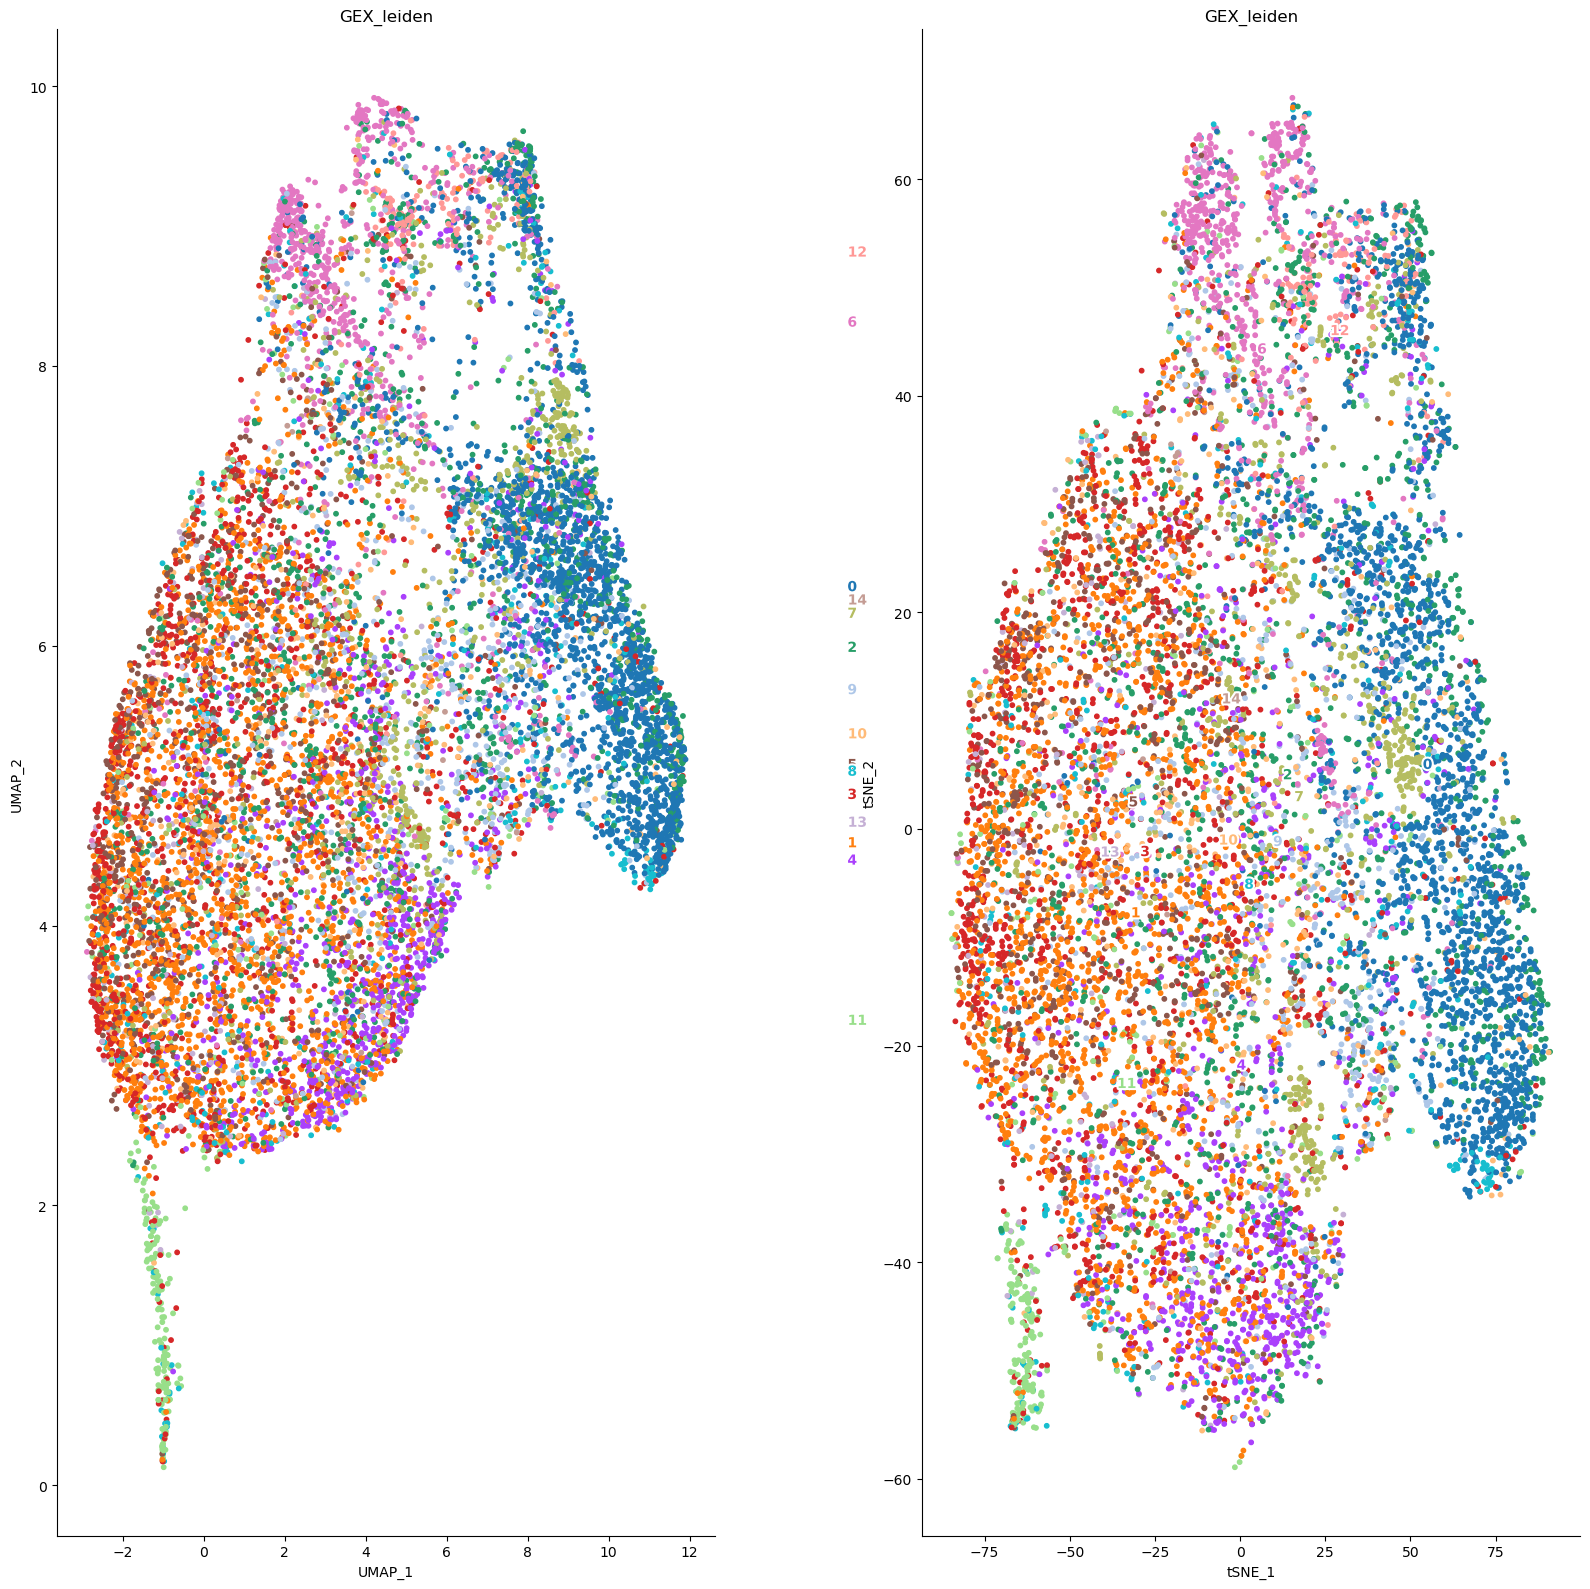

In [26]:
# visualize
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# specify color_dictionary (to keep consistent with scanpy cluster colors)
color_dict = {
        '0': "#1f77b4",
        '1': "#ff7f0e",
        '2': "#279e68",
        '3': "#d62728",
        '4': "#aa40fc",
        '5': "#8c564b",
        '6': "#e377c2",
        '7': "#b5bd61",
        '8': "#17becf",
        '9': "#aec7e8",
        '10': '#ffbb78',
        '11': '#98df8a',
        '12': '#ff9896',
        '13': '#c5b0d5',
        '14': '#c49c94'
    }

fig, axs = plt.subplots(ncols=2,nrows=1, figsize = (16, 16))


plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP_filtered', 
    variable = 'GEX_leiden', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_leiden': color_dict}
)

plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE_filtered', 
    variable = 'GEX_leiden', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_leiden': color_dict}
)

fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
plt.show()

In [27]:
import dill
with open(os.path.join(work_dir, 'scenicplus/scplus_obj_Results_hocomocov11.pkl'), 'wb') as f:
  dill.dump(scplus_obj, f)